In [2]:
# Загрузка библиотек

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

In [4]:
# Чтение данных
# Memory optimization

In [5]:
DATASET_TRAIN = pd.read_csv('C:/Users/alexs/Final project/train.csv')
DATASET_TEST = pd.read_csv('C:/Users/alexs/Final project/test.csv')


In [6]:
def reduce_memory_usage(df):
    
    start_memory = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_memory))
    
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_memory))
    print('Decreased by {:.1f}%'.format(100 * (start_memory - end_memory) / start_memory))
    
    return df

In [7]:
DATASET_TRAIN = reduce_memory_usage(DATASET_TRAIN)
DATASET_TEST = reduce_memory_usage(DATASET_TEST)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.47 MB
Decreased by 69.4%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 71.7%


In [8]:
df_train = DATASET_TRAIN
df_test = DATASET_TEST
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  uint16  
 1   DistrictId     10000 non-null  uint8   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

In [9]:
# Добавляем 'Price' в тестовые данные
df_test['Price'] = 0
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B,0
1,15856,74,2.0,69.263184,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,0
2,5480,190,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,0
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B,0
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,0


In [10]:
# Визуалиpуем целевую переменную

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


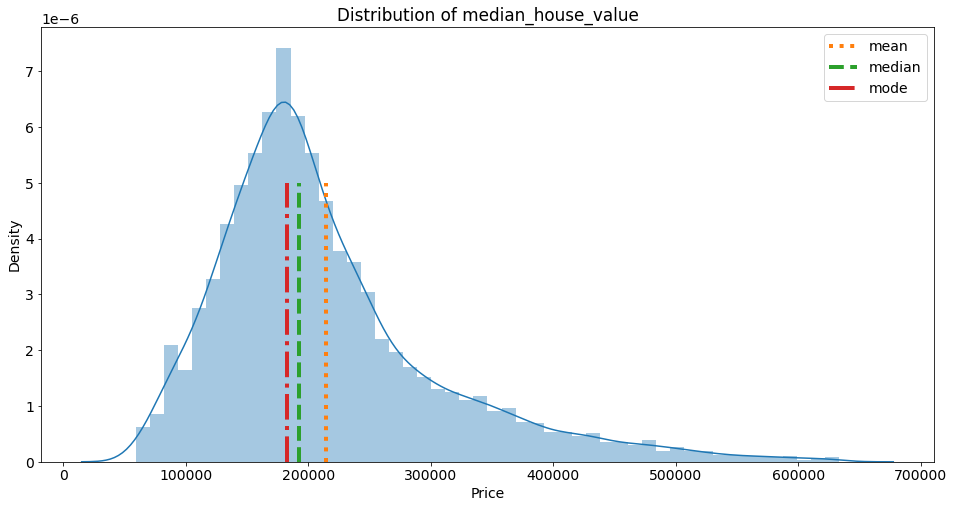

In [11]:
target_mean = round(df_train['Price'].mean(), 2)
target_median = df_train['Price'].median()
target_mode = df_train['Price'].mode()[0]

target_mean, target_median, target_mode

plt.figure(figsize = (16, 8))

sns.distplot(df_train['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

In [12]:
# Проверка данных

In [13]:
# Обработка признаков

In [14]:
df = pd.concat([df_train, df_test], axis=0)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             15000 non-null  uint16  
 1   DistrictId     15000 non-null  uint8   
 2   Rooms          15000 non-null  float32 
 3   Square         15000 non-null  float32 
 4   LifeSquare     11846 non-null  float32 
 5   KitchenSquare  15000 non-null  float32 
 6   Floor          15000 non-null  uint8   
 7   HouseFloor     15000 non-null  float32 
 8   HouseYear      15000 non-null  uint32  
 9   Ecology_1      15000 non-null  float32 
 10  Ecology_2      15000 non-null  category
 11  Ecology_3      15000 non-null  category
 12  Social_1       15000 non-null  uint8   
 13  Social_2       15000 non-null  uint16  
 14  Social_3       15000 non-null  uint8   
 15  Healthcare_1   7825 non-null   float32 
 16  Helthcare_2    15000 non-null  uint8   
 17  Shops_1        15000 non-null  u

In [16]:
# Обработка типов 'Category'

In [17]:
df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)

In [18]:
# Корреляция количественных признаков

In [19]:
df_non_binary_features = df[['DistrictId', 
                            'Rooms', 
                            'Square', 
                            'LifeSquare', 
                            'KitchenSquare', 
                            'Floor', 
                            'HouseFloor', 
                            'HouseYear', 
                            'Ecology_1', 
                            'Social_1', 
                            'Social_2', 
                            'Social_3', 
                            'Healthcare_1', 
                            'Helthcare_2', 
                            'Shops_1', 
                            'Price']]
df_non_binary_features.shape

(15000, 16)

In [20]:
df_non_binary_features.corr()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
DistrictId,1.000000,0.063861,-0.030043,-0.021397,0.042293,-0.123774,-0.150007,0.010853,0.070427,0.238062,0.160131,0.134509,0.307696,0.296534,0.168543,0.121846
Rooms,0.063861,1.000000,0.685344,0.152914,0.011596,-0.008179,-0.022225,-0.008731,-0.025705,0.074193,0.070390,0.006296,0.036978,0.052050,0.048053,0.261180
Square,-0.030043,0.685344,1.000000,0.218687,0.012461,0.113981,0.098070,-0.007613,-0.061655,-0.075502,-0.045846,0.025319,-0.046132,-0.036891,0.011542,0.260489
LifeSquare,-0.021397,0.152914,0.218687,1.000000,-0.000882,0.027075,0.032258,-0.002140,-0.023770,-0.049769,-0.039856,0.013081,-0.034083,-0.025998,-0.007327,0.053203
KitchenSquare,0.042293,0.011596,0.012461,-0.000882,1.000000,-0.010622,0.010683,0.000965,-0.003893,0.052472,0.046534,-0.017227,0.011231,0.044913,0.012194,0.021485
Floor,-0.123774,-0.008179,0.113981,0.027075,-0.010622,1.000000,0.434156,0.000703,-0.020034,-0.043501,-0.012720,0.001016,-0.131583,-0.059731,0.030623,0.054690
HouseFloor,-0.150007,-0.022225,0.098070,0.032258,0.010683,0.434156,1.000000,-0.000686,-0.015168,-0.025846,0.003794,-0.014608,-0.149781,-0.072358,0.023358,0.043730
HouseYear,0.010853,-0.008731,-0.007613,-0.002140,0.000965,0.000703,-0.000686,1.000000,0.001166,0.002430,0.001569,0.000640,-0.009705,0.009205,0.003005,0.007204
Ecology_1,0.070427,-0.025705,-0.061655,-0.023770,-0.003893,-0.020034,-0.015168,0.001166,1.000000,0.023236,0.006529,-0.122797,-0.036873,0.028627,-0.076433,-0.031755
Social_1,0.238062,0.074193,-0.075502,-0.049769,0.052472,-0.043501,-0.025846,0.002430,0.023236,1.000000,0.955933,0.022367,0.066335,0.522179,0.527161,0.123805


In [21]:
# Обработка выбросов

In [22]:
# Rooms

In [23]:
df['Rooms'].value_counts()

2.0     5910
1.0     5474
3.0     3334
4.0      240
5.0       25
0.0       10
6.0        3
10.0       2
19.0       1
17.0       1
Name: Rooms, dtype: int64

In [24]:
df['Rooms'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6., 10., 17., 19.], dtype=float32)

In [25]:
rooms_median = df['Rooms'].median()
df.loc[df['Rooms'] == 0, 'Rooms'] = 1
df.loc[df['Rooms'] >= 6, 'Rooms'] = rooms_median
df['Rooms'].value_counts(0)

2.0    5917
1.0    5484
3.0    3334
4.0     240
5.0      25
Name: Rooms, dtype: int64

In [26]:
# KitchenSquare

In [27]:
df['KitchenSquare'].value_counts(0)

1.0     3651
8.0     1912
5.0     1781
6.0     1633
10.0    1633
        ... 
29.0       1
23.0       1
61.0       1
54.0       1
73.0       1
Name: KitchenSquare, Length: 67, dtype: int64

In [28]:
df.loc[df['KitchenSquare'] < 6, 'KitchenSquare'] = 6
df.loc[df['KitchenSquare'] > 60, 'KitchenSquare'] = df.loc[df['KitchenSquare'] > 60, 'KitchenSquare'] / 10
df['KitchenSquare'].sort_values().unique()

array([  6. ,   6.1,   6.2,   6.3,   6.5,   6.6,   7. ,   7.2,   7.3,
         7.5,   7.8,   8. ,   8.4,   9. ,   9.6,   9.7,  10. ,  11. ,
        11.2,  12. ,  12.3,  13. ,  14. ,  15. ,  16. ,  17. ,  18. ,
        19. ,  20. ,  21. ,  22. ,  23. ,  24. ,  25. ,  26. ,  27. ,
        29. ,  30. ,  31. ,  32. ,  33. ,  34. ,  35. ,  36. ,  37. ,
        39. ,  40. ,  41. ,  42. ,  43. ,  44. ,  48. ,  51. ,  53. ,
        54. ,  57. ,  58. ,  60. ,  62. , 197. , 201.4], dtype=float32)

In [29]:
kitchensquare_median = df['KitchenSquare'].median()
df.loc[df['KitchenSquare'] >= 25, 'KitchenSquare'] = kitchensquare_median
df['KitchenSquare'].sort_values().unique()

array([ 6. ,  6.1,  6.2,  6.3,  6.5,  6.6,  7. ,  7.2,  7.3,  7.5,  7.8,
        8. ,  8.4,  9. ,  9.6,  9.7, 10. , 11. , 11.2, 12. , 12.3, 13. ,
       14. , 15. , 16. , 17. , 18. , 19. , 20. , 21. , 22. , 23. , 24. ],
      dtype=float32)

In [30]:
 # LifeSquare

In [31]:
df['LifeSquare'].sort_values().unique()

array([3.3348995e-01, 3.7061942e-01, 5.6726700e-01, ..., 6.3816321e+02,
       7.4805923e+03,           nan], dtype=float32)

In [32]:
df['LifeSquare'].value_counts(0)

20.844322    2
33.859653    2
23.891237    2
35.999996    1
30.667973    1
            ..
21.646847    1
2.912992     1
79.337334    1
18.334301    1
20.906406    1
Name: LifeSquare, Length: 11843, dtype: int64

In [33]:
#Находим коэфф, во сколько раз Square больше LifeSquare с учетом СНиП 31-01-2003 (с Изменениями)
coef_SLS = 38/(6 + 14)
coef_SLS

1.9

In [34]:
# Заменяем  значения с учетом коэффициента coef_SLS
df.loc[df['LifeSquare'] < 20, 'LifeSquare'] = df.loc[df['LifeSquare'] < 20, 'LifeSquare']/(1/coef_SLS)
df['LifeSquare'].sort_values().unique()

array([6.3363087e-01, 7.0417684e-01, 1.0778073e+00, ..., 6.3816321e+02,
       7.4805923e+03,           nan], dtype=float32)

In [35]:
lifesquare_median = df['LifeSquare'].median()
df.loc[df['LifeSquare'] < 20, 'LifeSquare'] = lifesquare_median
df.loc[df['LifeSquare'] > 200, 'LifeSquare'] = df.loc[df['LifeSquare'] > 200, 'LifeSquare'] / 10
df['LifeSquare'].sort_values().unique()

array([ 20.001862,  20.00341 ,  20.004328, ..., 174.83708 , 748.0592  ,
              nan], dtype=float32)

In [36]:
lifesquare_median = df['LifeSquare'].median()
df['LifeSquare'] = df['LifeSquare'].fillna(lifesquare_median)
df['LifeSquare'].sort_values().unique()

array([ 20.001862,  20.00341 ,  20.004328, ..., 170.71365 , 174.83708 ,
       748.0592  ], dtype=float32)

In [37]:
df.loc[df['LifeSquare'] > 200, 'LifeSquare'] = df.loc[df['LifeSquare'] > 200, 'LifeSquare'] / 10
df['LifeSquare'].sort_values().unique()

array([ 20.001862,  20.00341 ,  20.004328, ..., 169.9017  , 170.71365 ,
       174.83708 ], dtype=float32)

In [38]:
# Square

In [39]:
df['Square'].sort_values().unique()

array([  1.1368588,   1.3785427,   1.9757689, ..., 409.42517  ,
       604.706    , 641.0652   ], dtype=float32)

In [40]:
df['Square'].value_counts(0)

66.793839    2
41.692863    2
40.407391    2
80.794792    2
35.091915    2
            ..
78.663589    1
44.652912    1
80.072876    1
39.389332    1
44.000046    1
Name: Square, Length: 14989, dtype: int64

In [41]:
#Находим коэфф, во сколько раз Square больше KitchenSquare с учетом СНиП 31-01-2003 (с Изменениями)
coef_SKS = 38/6
coef_SKS

6.333333333333333

In [42]:
# Заменяем значения с учетом коэффициента coef_SKS
df.loc[df['Square'] < 38, 'Square'] = df.loc[df['Square'] < 38, 'Square']/(1/coef_SKS)
df['Square'].sort_values().unique()

array([  7.200106,   8.73077 ,  12.513204, ..., 409.42517 , 604.706   ,
       641.0652  ], dtype=float32)

In [44]:
df.loc[df['Square'] > 200, 'Square'] = df.loc[df['Square'] > 200, 'Square'] / 10
df['Square'].sort_values().unique()

array([  7.200106,   8.73077 ,  12.513204, ..., 199.91638 , 199.98738 ,
       199.9976  ], dtype=float32)

In [45]:
lifesquare_median = df['Square'].median()
df['Square'] = df['Square'].fillna(lifesquare_median)
df['Square'].sort_values().unique()

array([  7.200106,   8.73077 ,  12.513204, ..., 199.91638 , 199.98738 ,
       199.9976  ], dtype=float32)

In [46]:
# Floor, HouseFloor

In [47]:
df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,
        99., 117.], dtype=float32)

In [48]:
df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 37, 38,
       42, 46, 78], dtype=uint8)

In [49]:
housefloor_median = df['HouseFloor'].median()

df['HouseFloor_outlier'] = 0
df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1

      
df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = housefloor_median
df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor']

In [50]:
df['HouseFloor'].sort_values().unique()

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99.,
       117.], dtype=float32)

In [51]:
df['Floor'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       28., 31., 32., 33., 34., 37., 38., 42., 46.], dtype=float32)

In [52]:
# HouseYear

In [53]:
df['HouseYear'].sort_values().unique()

array([    1908,     1909,     1910,     1911,     1912,     1914,
           1916,     1917,     1918,     1919,     1920,     1926,
           1927,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1943,     1947,
           1948,     1949,     1950,     1951,     1952,     1953,
           1954,     1955,     1956,     1957,     1958,     1959,
           1960,     1961,     1962,     1963,     1964,     1965,
           1966,     1967,     1968,     1969,     1970,     1971,
           1972,     1973,     1974,     1975,     1976,     1977,
           1978,     1979,     1980,     1981,     1982,     1983,
           1984,     1985,     1986,     1987,     1988,     1989,
           1990,     1991,     1992,     1993,     1994,     1995,
           1996,     1997,     1998,     1999,     2000,     2001,
           2002,     2003,     2004,     2005,     2006,     2

In [54]:
current_year = 2021    
df['HouseYear_outlier'] = 0
df.loc[df['HouseYear'] > 2021, 'HouseYear_outlier'] = 1       
df.loc[df['HouseYear'] > current_year, 'HouseYear'] = current_year

df['HouseYear'].sort_values().unique()

array([1908, 1909, 1910, 1911, 1912, 1914, 1916, 1917, 1918, 1919, 1920,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
       1937, 1938, 1939, 1940, 1941, 1942, 1943, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021], dtype=uint32)

In [55]:
# HealthCare

In [56]:
healthcare_1_for_predict = df.loc[df['Healthcare_1'].isnull(), ['DistrictId', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2']]
healthcare_1_X = df.loc[df['Healthcare_1'].notnull(), ['DistrictId', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2']]
healthcare_1_y = np.ravel(df.loc[df['Healthcare_1'].notnull(), ['Healthcare_1']])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(healthcare_1_X, healthcare_1_y, test_size=0.3, random_state=151)
rfc = RandomForestClassifier(max_depth=14, n_estimators=200)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(accuracy_score(y_test, y_pred))
rfc.fit(healthcare_1_X, healthcare_1_y)
healthcare_1_pred = rfc.predict(healthcare_1_for_predict)
df.loc[df['Healthcare_1'].isnull(), ['Healthcare_1']] = healthcare_1_pred

1.0


In [58]:
df.isnull().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Healthcare_1          0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
HouseFloor_outlier    0
HouseYear_outlier     0
dtype: int64

In [59]:
# Отбор признаков

In [60]:
feature_names = ['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']
target_name = ['Price']
id_stat = ['Id']

In [61]:
df = df[id_stat + feature_names + target_name]
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7.0,9.0,1969,0.089040,1,1,33,7976,5,990.0,0,11,1,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7.0,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.437500
2,4765,53,2.0,44.947952,29.197611,6.0,8.0,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8.0,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11.0,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531250


In [62]:
# Разделяем df

In [63]:
df_test = df.loc[df['Price'] == 0]
df_train = df.loc[df['Price'] != 0]

In [64]:
# Первая модель для определения важности признаков

In [67]:
X_train, X_test, y_train, y_test = train_test_split(df_train[feature_names], df_train[target_name], test_size=0.2)
rf_model_first = RandomForestRegressor(max_depth=16, n_estimators=800)
rf_model_first.fit(X_train, np.ravel(y_train))
y_test_preds = rf_model_first.predict(X_test)
r2(y_test, y_test_preds)

0.7176972531123142

In [68]:
importance = list(zip(rf_model_first.feature_importances_, feature_names))
sorted(importance, reverse=True)

[(0.3160569141689549, 'Rooms'),
 (0.172760212338928, 'Square'),
 (0.07337595424589556, 'Social_3'),
 (0.06850450025428771, 'Social_2'),
 (0.0504558704412115, 'Social_1'),
 (0.049324214630200515, 'DistrictId'),
 (0.041436823161066116, 'HouseYear'),
 (0.04111615475221654, 'Ecology_1'),
 (0.04075555296556857, 'KitchenSquare'),
 (0.04073249246280416, 'LifeSquare'),
 (0.028124643708391146, 'HouseFloor'),
 (0.026771050803905207, 'Healthcare_1'),
 (0.022445683671542392, 'Floor'),
 (0.017492261804264882, 'Shops_1'),
 (0.008408043502807681, 'Helthcare_2'),
 (0.000988563475445854, 'Shops_2'),
 (0.0008376809282674279, 'Ecology_3'),
 (0.0004133826842418503, 'Ecology_2')]

In [69]:
importance_features = ['Rooms', 'Square', 'Social_1', 'Social_2', 'KitchenSquare','Social_3', 'DistrictId', 'LifeSquare', 'Ecology_1',  'HouseYear', 'Healthcare_1', 'HouseFloor',  'Floor', 'Shops_1']

In [70]:
# Делим датафрейм на тестовые и тренировочные данные

In [71]:
X_train, X_test, y_train, y_test = train_test_split(df_train[importance_features], df_train['Price'], random_state = 151, test_size=0.3)

In [72]:
rf_model = RandomForestRegressor(max_depth=16, n_estimators=300, random_state = 65)
rf_model.fit(X_train, np.ravel(y_train))
y_test_preds = rf_model.predict(X_test)

print(f' max_depth=16, n_estimators=300 r2_test: {r2(y_test, y_test_preds)}')

 max_depth=16, n_estimators=300 r2_test: 0.7580665045843953


In [73]:
rf_model.fit(df_train[importance_features], df_train['Price'])

RandomForestRegressor(max_depth=16, n_estimators=300, random_state=65)

In [74]:
y_test_preds_res = rf_model.predict(df_test[importance_features])
y_test_preds_res

array([161512.94390408, 234582.24908089, 319719.50364642, ...,
       326406.6231452 , 184895.10833318, 175180.81432314])

In [75]:
df_test['Price'] = y_test_preds_res
df_test

<ipython-input-75-98892491d526>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Price'] = y_test_preds_res


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,725,58,2.0,49.882645,33.432781,6.0,6.0,14.0,1972,0.310199,1,1,11,2748,1,32.0,0,0,1,161512.943904
1,15856,74,2.0,69.263184,34.398117,6.0,1.0,1.0,1977,0.075779,1,1,6,1437,3,1084.0,0,2,1,234582.249081
2,5480,190,1.0,86.119522,30.301666,12.0,2.0,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,1,319719.503646
3,15664,47,2.0,73.046608,51.940842,9.0,22.0,22.0,2007,0.101872,1,1,23,4583,3,1084.0,3,3,1,346388.501854
4,14275,27,1.0,47.527111,43.387569,6.0,17.0,17.0,2017,0.072158,1,1,2,629,1,35.0,0,0,0,143832.927989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809795,6.0,5.0,9.0,1973,0.000170,1,1,36,5992,0,1183.0,1,1,1,245878.402799
4996,4695,1,1.0,40.198471,21.807060,10.0,12.0,17.0,2017,0.007122,1,1,1,264,0,540.0,0,1,1,126706.958434
4997,5783,12,3.0,77.842178,48.282623,9.0,22.0,22.0,1989,0.090799,1,1,74,19083,2,1322.0,5,15,1,326406.623145
4998,4780,62,2.0,81.305222,34.398117,6.0,4.0,12.0,1977,0.072158,1,1,2,629,1,35.0,0,0,0,184895.108333


In [76]:
RES_DATASET_PATH = 'AVSokolov_predictions_6_1.csv'
df_test[['Id', 'Price']].to_csv(RES_DATASET_PATH, index=None, encoding='utf-8')